# Ask a Manager Salary Survey Analysis

## Modelling salary based on age, location, experience, and job title
### by Brian Bell

For this project, I want to look at how much data scientists make on average, compared to other professions. 

This project will be using the survey data from the Ask a Manager Website. This survey asks the respondents infomation on age, work industry, job title, salary, currency, location, and years of experience.
<br> <br>
For the age, experience, and currency fields, the respondent had to choose from several choices. This makes cleaning the data relatively easy. For the industry, job title, and salary fields, the respondent could type in whatever they chose to. Because of that, those fields require some cleaning to be able to use for analysis.
<br><br>
A multiple linear regression model will be used to for the analysis.

The survey can be found here: https://www.askamanager.org/2019/04/how-much-money-do-you-make-3.html <br>
The data is in a google spreadsheet that can be found here: https://docs.google.com/spreadsheets/d/1rGCKXIKt-7l5gX06NAwO3pjqEHh-oPXtB8ihkp0vGWo/edit#gid=382484678 <br>

In [1]:
import pandas as pd
import numpy as np
import re
import string  # For punctuation and whitespace

In [2]:
salary_file = 'Data/salary_survey.csv'

cols = ['timestamp', 'age', 'industry', 'job_title', 'salary', 'currency', 'location',
        'experience', 'context', 'other_currency']

salary_df = pd.read_csv(salary_file, skiprows = 2, names = cols).drop('timestamp', axis = 1)


# Cleaning Salary
Examples of difficult rows. As is shown, this the format for this column varies greatly.

In [3]:
salary_df.iloc[[10519 , 14620, 11331, 23262, 1499, 23014], :]

,age,industry,job_title,salary,currency,location,experience,context,other_currency
10519,35-44,Education,Teacher K-12,"$72,000",USD,"Abington, MA USA",11 - 20 years,Instructional Technology Specialist,NaN
14620,25-34,Biotech Venture Capital,Associate,123000 (+20% performance bonus),USD,"Boston, MA",5-7 years,Have a PhD,NaN
11331,35-44,IT,Head of Internal Communications and Engagement,50 000,GBP,United Kingdom,11 - 20 years,NaN,NaN
23262,35-44,Inventory,Survey Specialist,~31200,USD,United States,11 - 20 years,Specialized position that involves training fo...,NaN
1499,25-34,Television and Film,Specialist,150k,USD,"LA, CA, USA",5-7 years,My company does title-downs so I'm a Manager a...,NaN
23014,under 18,NaN,Golf Mower,min wage,USD,NaN,1 year or less,NaN,NaN


A particularly noteworthy entry (put in by a software engineer).

In [4]:
# Notable entry
salary_df.loc[33639, 'salary']

'Normalize and sanitize this field!'

### Check for null salaries and drop them

In [5]:
salary_df.isnull().sum()

age                   0
industry            961
job_title             2
salary                3
currency              0
location           1752
experience            0
context           26457
other_currency    33797
dtype: int64

In [6]:
salary_df.dropna(subset = ['salary'], inplace = True)

Drop known bad row(s).

In [7]:
salary_df.loc[14706, :]

age                        65 or over
industry                  Healthcare 
job_title                        Slut
salary                         $10.00
currency                          USD
location          Compton California 
experience              31 - 40 years
context                   Total slut?
other_currency                    NaN
Name: 14706, dtype: object

In [8]:
salary_df.drop(14706, inplace = True)

Take care of salaries containing "month" manually because of certain diffult entries.

In [9]:
def filter_month(row):
    if re.search(r'month', row.salary):
        return True
    return False
        
salary_df.loc[salary_df.apply(filter_month, axis = 1),  :]

,age,industry,job_title,salary,currency,location,experience,context,other_currency
3187,25-34,Recruiting,Staffing Coordinator,"49,500 plus monthly 10% bonuses",USD,"Chicago, Il",5-7 years,NaN,NaN
3191,25-34,Theatre / Performing Arts,Wardrobe Supervisor,"42000 (10ish month contract like teachers, sal...",USD,"Washington DC, USA",8 - 10 years,NaN,NaN
8161,25-34,Hotel,Front Office Agent,Approx. 1200 a month,EUR,Germany,2 - 4 years,NaN,NaN
12538,45-54,Public education,Art Masterpiece Program Coordinator,$17K for a 9 month calendar,USD,"Chandler, AZ, USA",11 - 20 years,I run the elementary schools art program at ou...,NaN
34051,25-34,IT,Data scientist,37000/month,SEK,Stockholm,1 year or less,NaN,NaN


In [10]:
salary_df.loc[3187, 'salary'] = '49500'
salary_df.loc[3191, 'salary'] = '42000'
salary_df.loc[8161, 'salary'] = '14400'
salary_df.loc[12538, 'salary'] = '17000'
salary_df.loc[34051, 'salary'] = '444000'

I will manually change this salary too because of the format.

In [11]:
salary_df.loc[24626, 'salary']

'$1.4M'

In [12]:
salary_df.loc[24626, 'salary'] = '1,400,000'

In [13]:
punctuation = ',\'£€$'
whitespace = string.whitespace


def clean_salary(text):
    
    #  Entries with a '-' in them. Generally, the largest value found is the correct value
    if '-' in text:
        options = []
        for split in text.split('-'):
            options.append(float(clean_salary(split)))
        chosen = max(options)
        return str(chosen)            
    
    # Match entries written as 123k
    match_k = re.search(r'(\d+) ?[kK]', text)
    if match_k:
        return match_k.group(1) + "000"
    
    # match num in format 1,234,567
    match_mills = re.search(r'(\d{1,3},?\d{3},?\d{3})', text)
    if match_mills:
        return match_mills.group(1).replace(',', '')
    
    # Match num in format 12,345
    match_thousands = re.search(r'(\d{1,3},?\d{3})', text)
    if match_thousands:
        return match_thousands.group(1).replace(',', '')
    
    # Remove punctuation and whitespace  
    text_clean = "".join([str.lower(c) for c in text if c not in punctuation and c not in whitespace])
    
    # Return nan if it has no numbers
    if not re.search(r'\d', text_clean):
        return np.nan
    
    # Match hourly
    match_hr = re.search(r'hr|hour', text_clean)
    if match_hr:
        match_hr_num = re.search(r'([\d]+\.?[\d]+)', text_clean)
        if match_hr_num:
            hr_rate = float(match_hr_num.group(1))
            return str(hr_rate * 2080)
        else:
            return np.nan   
        
    # Match salary at start
    match_start = re.match(r'^([\d]+\.?[\d]+)', text_clean)
    if match_start:
        return match_start.group(1)
    
    # Match salary at end
    match_start = re.search(r'([\d]+\.?[\d]+)$', text_clean)
    if match_start:
        return match_start.group(1)
    
    return np.nan
    
    

In [14]:
salary_df['salary_clean'] = salary_df.salary.apply(clean_salary).astype('float')

# Drop any remaining entries
salary_df.dropna(subset = ['salary_clean'], inplace = True)

Several of the remaining salaries are less than 100. For these salaries, it is assumed they left off the "thousand" part and really should be larger.

In [15]:
salary_df.loc[salary_df.salary_clean < 1000, :].head()

,age,industry,job_title,salary,currency,location,experience,context,other_currency,salary_clean
467,35-44,Biotech,QA Specialist,$75.00,USD,"Gaithersburg, MD",11 - 20 years,NaN,NaN,75.00
696,45-54,Legal,Paralegal,42,USD,Spartanburg/SC/USA,21 - 30 years,Personal injury,NaN,42.00
1042,25-34,Tech,Software Research Engineer,120,USD,Portland Oregon USA,1 year or less,NaN,NaN,120.00
1126,18-24,Finance,Broker,25.25,USD,Ga,31 - 40 years,NaN,NaN,25.25
1700,35-44,Consulting,Regional Manager,125,USD,"Chicago, IL, US",8 - 10 years,I'm a lead consultant working primarily for go...,NaN,125.00


In [16]:
salary_df['salary_clean'] = salary_df.salary_clean.apply(lambda salary: 1000 * salary if salary < 1000 else salary)

In [17]:
salary_df.head()

,age,industry,job_title,salary,currency,location,experience,context,other_currency,salary_clean
0,35-44,Government,Talent Management Asst. Director,75000,USD,"Nashville, TN",11 - 20 years,NaN,NaN,75000.0
1,25-34,Environmental nonprofit,Operations Director,"65,000",USD,"Madison, Wi",8 - 10 years,NaN,NaN,65000.0
2,18-24,Market Research,Market Research Assistant,"36,330",USD,"Las Vegas, NV",2 - 4 years,NaN,NaN,36330.0
3,25-34,Biotechnology,Senior Scientist,34600,GBP,"Cardiff, UK",5-7 years,NaN,NaN,34600.0
4,25-34,Healthcare,Social worker (embedded in primary care),55000,USD,"Southeast Michigan, USA",5-7 years,NaN,NaN,55000.0


# Cleaning Age and Experience
These values are categorical variables with a natural ordering. The midway point between the range of values was used to estimate the true value.

In [18]:
age_encoding = {'under 18':17, '18-24':21.5,'25-34':30, '35-44':40, '45-54':50, '55-64':60, '65 or over':70}
salary_df['age_num'] = salary_df.age.map(age_encoding)

In [19]:
exp_encoding = {'1 year or less':1, '2 - 4 years':3, '5-7 years':6, '8 - 10 years':9,
                '11 - 20 years':15.5, '21 - 30 years':25.5, '31 - 40 years':35.5, '41 years or more':50}
salary_df['exp_num'] = salary_df.experience.map(exp_encoding)

In [20]:
salary_df.head()

,age,industry,job_title,salary,currency,location,experience,context,other_currency,salary_clean,age_num,exp_num
0,35-44,Government,Talent Management Asst. Director,75000,USD,"Nashville, TN",11 - 20 years,NaN,NaN,75000.0,40.0,15.5
1,25-34,Environmental nonprofit,Operations Director,"65,000",USD,"Madison, Wi",8 - 10 years,NaN,NaN,65000.0,30.0,9.0
2,18-24,Market Research,Market Research Assistant,"36,330",USD,"Las Vegas, NV",2 - 4 years,NaN,NaN,36330.0,21.5,3.0
3,25-34,Biotechnology,Senior Scientist,34600,GBP,"Cardiff, UK",5-7 years,NaN,NaN,34600.0,30.0,6.0
4,25-34,Healthcare,Social worker (embedded in primary care),55000,USD,"Southeast Michigan, USA",5-7 years,NaN,NaN,55000.0,30.0,6.0


In [21]:
salary_df.dropna(subset=['job_title', 'industry'], inplace=True)

# Job Categories
The industry and job title is a particulary challenging area to tackle. Instead of trying to match each job specifically, they will be grouped into general areas. Since data science is the area I am most interested in, that one will be taken in a slightly more specific way.

In [22]:
# Main field of interest is data science
# I want to be able to specifically capture these terms
data_science_jobs = ['data science', 'data scientist', 'data engineer', 'machine learning', 'data engineer']

job_cats = {
    'analyst' : ['data', 'analyst', 'statistician', 'statistics'],
    'technologly' : ['tech', 'technology', 'it', 'information', 'programmer', 'programming', 'software', 'coder', 'solutions'],
    'academic' : ['education', 'ed', 'higher', 'library', 'librarian', 'professor', 'acedamia', 'academic', 'teacher'],
    'medical' : ['healthcare', 'ems', 'emt', 'paramedic', 'nurse', 'doctor', 'pharmacy', 'pharmaceutical', 'bio', 'vet', 'vetinary'],
    'marketing' : ['marketing', 'market'],
    'finance' : ['accounting', 'actuary', 'insurance', 'bank', 'banking'],
    'office' : ['secretary', 'human', 'resources', 'hr', 'office'],
    'management' : ['management', 'ceo', 'cfo'],
    'food service' : ['food', 'caterer', 'catering', 'cook', 'waiter', 'waitress', 'server', 'bartender', 'line'],
    'laborer' : ['construction', 'road', 'roadwork', 'electrician', 'plumber', 'pipe', 'fitter']
}

Look if any of the words for each category are present in either column for classification.

In [23]:
from nltk import word_tokenize

def get_job_category(salary_row):
    
    job = str.lower(salary_row.job_title)
    ind = str.lower(salary_row.industry)
    
    job += " " + ind
    
    for term in data_science_jobs:
        m_job = re.search(term, job)
        if m_job:
            return "data_scientist"    
    
    job = word_tokenize(job)   
        
    for word in job:
        for key, values in job_cats.items():
            if word in values:
                return key

    return np.nan

In [24]:
salary_df['job_category'] = salary_df.apply(get_job_category, axis = 1)

Any jobs that do not match the descriptions above will be simply removed. Doing so removes a decent amount of data, but it leaves enough information to perform the analysis.

In [25]:
print('Number of entries before dropping data:', len(salary_df))
salary_df.dropna(subset = ['job_category'], inplace = True)
print('Number of entries after dropping data with NaN jobs:', len(salary_df))

Number of entries before dropping data: 33059
Number of entries after dropping data with NaN jobs: 16801


In [26]:
salary_df.head()

,age,industry,job_title,salary,currency,location,experience,context,other_currency,salary_clean,age_num,exp_num,job_category
0,35-44,Government,Talent Management Asst. Director,75000,USD,"Nashville, TN",11 - 20 years,NaN,NaN,75000.0,40.0,15.5,management
2,18-24,Market Research,Market Research Assistant,"36,330",USD,"Las Vegas, NV",2 - 4 years,NaN,NaN,36330.0,21.5,3.0,marketing
4,25-34,Healthcare,Social worker (embedded in primary care),55000,USD,"Southeast Michigan, USA",5-7 years,NaN,NaN,55000.0,30.0,6.0,medical
5,25-34,Information Management,Associate Consultant,"45,000",USD,"Seattle, WA",8 - 10 years,NaN,NaN,45000.0,30.0,9.0,technologly
7,25-34,Higher Education,Student Records Coordinator,"54,371",USD,Philadelphia,8 - 10 years,equivalent to Assistant Registrar,NaN,54371.0,30.0,9.0,academic


# Currency
This field will be used to transform the all of the salaries to USD. Since location is another incredible difficult field to clean, it will be used as a proxy variable to esimate location.

In [27]:
exchange_rate = {
    'USD' : 1,
    'GBP' : 1.27,
    'CAD' : .74,
    'EUR' : 1.13,
    'SEK' : .11,
    'AUD/NZD' : .7,
    'JPY' : .0091,
    'CHF' : 1.04,
    'HKD' : .13,
    'ZAR' : .059,
    'Other' : np.nan, 
}

def convert_salary(salary_row):
    rate = exchange_rate[salary_row.currency]
    return rate * salary_row.salary_clean


In [28]:
salary_df['salary_usd'] = salary_df.apply(convert_salary, axis = 1)

In [29]:
salary_df.dropna(subset = ['job_category', 'salary_usd'], inplace = True)

# Exploring Data

In [30]:
# I will remove this point for visualization, because it makes the visualization look better. It is an extreme outlier.
salary_df_trim = salary_df.drop(23777)

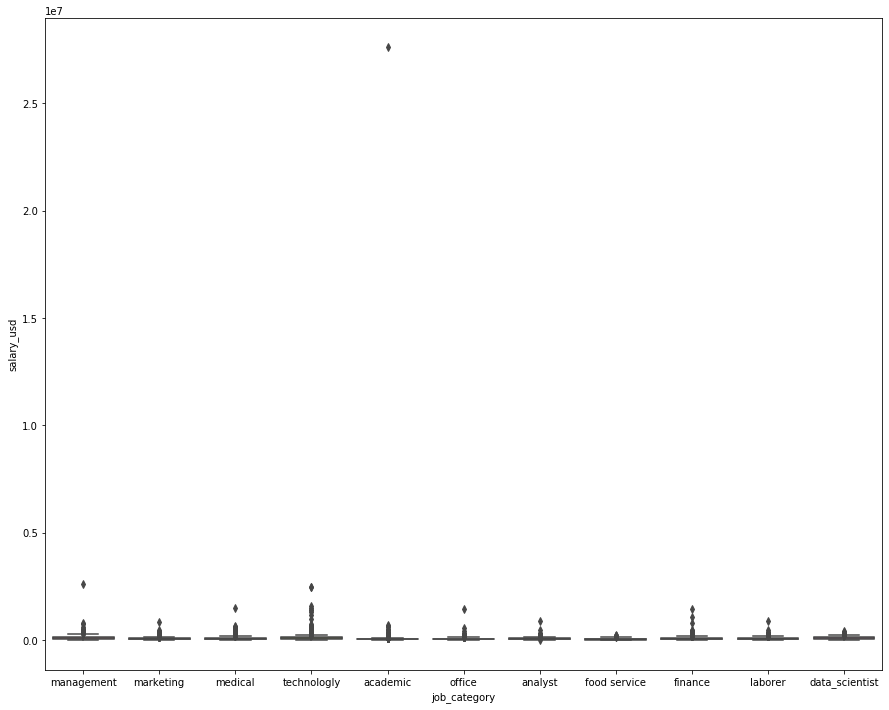

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(15, 12))

p = sns.boxplot(x = 'job_category', y = 'salary_usd', data = salary_df_trim)

plt.show()

From this graph, the data appears to be heavily right-skewed in every category.

In [32]:
salary_df.groupby('job_category').salary_usd.mean()

job_category
academic           73960.620132
analyst            79531.844626
data_scientist    124729.434118
finance            94769.308343
food service       65196.268776
laborer            95607.609035
management        155015.687984
marketing          83910.456908
medical           104898.328510
office             71963.303760
technologly       123925.633111
Name: salary_usd, dtype: float64

In [33]:
salary_df.groupby('job_category').salary_usd.median()

job_category
academic           58000.0
analyst            72550.0
data_scientist    114500.0
finance            76000.0
food service       55000.0
laborer            80000.0
management         95000.0
marketing          70000.0
medical            85000.0
office             60000.0
technologly       108000.0
Name: salary_usd, dtype: float64

Looking at the mean and median confirm the data is right-skewed. One thing to note, is that data science has the highest median salary.

# First Analysis
For this analysis, a simple linear regression will be used with salary (in USD) as the response variable and age, years of experience, job category, and currency type (as a proxy for location) will be the predictors.

The statsmodel package is used to create the linear regression model. The plots are created using matplotlib.
<br><br>
All of the analysis code below is based off this article: https://towardsdatascience.com/going-from-r-to-python-linear-regression-diagnostic-plots-144d1c4aa5a
<br><br>
The code for the diagnostics plots are based off of the code by the  GitHub user j-sadowski: https://gist.github.com/j-sadowski

In [34]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.nonparametric.smoothers_lowess import lowess
from matplotlib import rcParams
import scipy.stats as stats

In [35]:
cols = list(salary_df.columns[10:-1])
cols.append(salary_df.columns[4])

preds = ' + '.join(cols)

In [36]:
model = smf.ols(formula = f'salary_usd ~ {preds}', data = salary_df)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             salary_usd   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     13.91
Date:                Sun, 07 Jun 2020   Prob (F-statistic):           3.70e-49
Time:                        22:24:52   Log-Likelihood:            -2.3160e+05
No. Observations:               16701   AIC:                         4.633e+05
Df Residuals:                   16679   BIC:                         4.634e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

The adjusted $R^2$ value is incredible low at 0.016. However, all job category and experience are statistically significant predictors (at the $5\%$ significance level).

### Collinearity
The results indicate there might be strong collinearity among the predictors. A quick check shows that this is indeed present. On the of two variables should be dropped from the model. Since experience his a higher correlation with salary, I will include that in my final model.

In [37]:
salary_df.loc[:, ['salary_usd'] + cols].corr()

,salary_usd,age_num,exp_num
salary_usd,1.000000,0.074085,0.089203
age_num,0.074085,1.000000,0.808195
exp_num,0.089203,0.808195,1.000000


### Diagnostic Plots

In [38]:
def residual_fitted_plot(results, ax):
    '''
    Returns residual vs fitted plot and the 3 largest residuals
    '''
    residuals = results.resid
    fitted = results.fittedvalues
    smoothed = lowess(residuals,fitted)
    top3 = abs(residuals).sort_values(ascending = False)[:3]
    
    ax.scatter(fitted, residuals, edgecolors = 'k', facecolors = 'none')
    ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')
    ax.set_ylabel('Residuals')
    ax.set_xlabel('Fitted Values')
    ax.set_title('Residuals vs. Fitted')
    ax.plot([min(fitted),max(fitted)],[0,0],color = 'k',linestyle = ':', alpha = .3)

    for i in top3.index:
        ax.annotate(i,xy=(fitted[i],residuals[i]))
        
    return (plt, top3)

In [39]:
def qq_plot(results, ax):
    '''
    Returns qq plot and the 3 residuals with the largest deviation from normallity
    '''
    sorted_student_residuals = pd.Series(results.get_influence().resid_studentized_internal)
    sorted_student_residuals.index = results.resid.index
    sorted_student_residuals = sorted_student_residuals.sort_values(ascending = True)
    df = pd.DataFrame(sorted_student_residuals)
    df.columns = ['sorted_student_residuals']
    df['theoretical_quantiles'] = stats.probplot(df['sorted_student_residuals'], dist = 'norm', fit = False)[0]
    rankings = abs(df['sorted_student_residuals']).sort_values(ascending = False)
    top3 = rankings[:3]

    x = df['theoretical_quantiles']
    y = df['sorted_student_residuals']
    ax.scatter(x,y, edgecolor = 'k',facecolor = 'none')
    ax.set_title('Normal Q-Q')
    ax.set_ylabel('Standardized Residuals')
    ax.set_xlabel('Theoretical Quantiles')
    ax.plot([np.min([x,y]),np.max([x,y])],[np.min([x,y]),np.max([x,y])], color = 'r', ls = '--')
    for val in top3.index:
        ax.annotate(val,xy=(df['theoretical_quantiles'].loc[val],df['sorted_student_residuals'].loc[val]))
    return (plt, top3)    
    


In [40]:
def leverage_plot(results, ax):
    '''
    Returns residuals vs leverage plot and the 3 highest leverage points
    '''
    student_residuals = pd.Series(results.get_influence().resid_studentized_internal)
    student_residuals.index = results.resid.index
    df = pd.DataFrame(student_residuals)
    df.columns = ['student_residuals']
    df['leverage'] = results.get_influence().hat_matrix_diag
    smoothed = lowess(df['student_residuals'],df['leverage'])
    sorted_student_residuals = abs(df['student_residuals']).sort_values(ascending = False)
    top3 = sorted_student_residuals[:3]

    x = df['leverage']
    y = df['student_residuals']
    xpos = max(x)+max(x)*0.01  
    ax.scatter(x, y, edgecolors = 'k', facecolors = 'none')
    ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')
    ax.set_ylabel('Studentized Residuals')
    ax.set_xlabel('Leverage')
    ax.set_title('Residuals vs. Leverage')
    ax.set_ylim(min(y)-min(y)*0.15,max(y)+max(y)*0.15)
    ax.set_xlim(-0.01,max(x)+max(x)*0.05)
    plt.tight_layout()
    for val in top3.index:
        ax.annotate(val,xy=(x.loc[val],y.loc[val]))

    cooksx = np.linspace(min(x), xpos, 50)
    p = len(results.params)
    poscooks1y = np.sqrt((p*(1-cooksx))/cooksx)
    poscooks05y = np.sqrt(0.5*(p*(1-cooksx))/cooksx)
    negcooks1y = -np.sqrt((p*(1-cooksx))/cooksx)
    negcooks05y = -np.sqrt(0.5*(p*(1-cooksx))/cooksx)

    ax.plot(cooksx,poscooks1y,label = "Cook's Distance", ls = ':', color = 'r')
    ax.plot(cooksx,poscooks05y, ls = ':', color = 'r')
    ax.plot(cooksx,negcooks1y, ls = ':', color = 'r')
    ax.plot(cooksx,negcooks05y, ls = ':', color = 'r')
    ax.plot([0,0],ax.get_ylim(), ls=":", alpha = .3, color = 'k')
    ax.plot(ax.get_xlim(), [0,0], ls=":", alpha = .3, color = 'k')
    ax.annotate('1.0', xy = (xpos, poscooks1y[-1]), color = 'r')
    ax.annotate('0.5', xy = (xpos, poscooks05y[-1]), color = 'r')
    ax.annotate('1.0', xy = (xpos, negcooks1y[-1]), color = 'r')
    ax.annotate('0.5', xy = (xpos, negcooks05y[-1]), color = 'r')
    ax.legend()
    
    return (plt, top3)

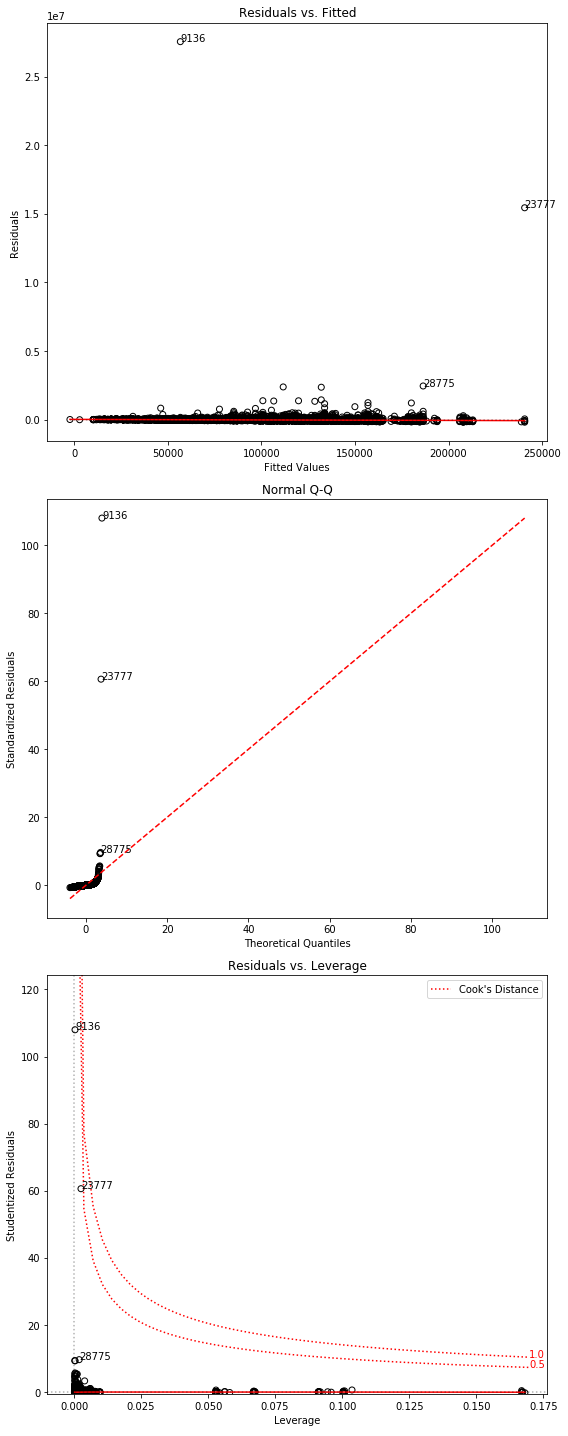

In [41]:
fig, axes = plt.subplots(3, figsize = (8, 20))

p1, top3_1 = residual_fitted_plot(results, axes[0])
p2, top3_2 = qq_plot(results, axes[1])
p3, top3_3 = leverage_plot(results, axes[2])

top3 = top3_1 + top3_2 + top3_3

plt.show()

### Discussion of Plots

The plot of the residuals vs. the fitted values does not appear to show anything alarming. The residuals look to have constant variance.
<br><br>
The Q-Q plot shows the a linear model might not be the best fit for this data. Taking the log of salary might provide a model with a better fit for the data.
<br><br>
Finally, the residuals vs. leverage plot show no points with very high leverage (i.e. having a Cook's distance greater than .5).

### Examine outliers
Entry 9136 clearly should be removed since they listed USD as currency, but then listed Keroean Won in other currency. The other two points I will leave in since they appear to be valid entries.

In [42]:
salary_df.loc[top3.index, :]

,age,industry,job_title,salary,currency,location,experience,context,other_currency,salary_clean,age_num,exp_num,job_category,salary_usd
9136,25-34,TEFL,Native Speaking English Teacher,"~27,600,000",USD,"Seoul, South Korea",2 - 4 years,NaN,Korean Won,27600000.0,30.0,3.0,academic,27600000.0
23777,65 or over,Consumer Software & Hardware,CEO,"$15,682,219",USD,"Cupertino, California, USA",41 years or more,Chief Executive Officer at Apple,NaN,15682219.0,70.0,50.0,management,15682219.0
28775,55-64,Healthcare,CEO,2645000,USD,New York,21 - 30 years,Business Founder,NaN,2645000.0,60.0,25.5,management,2645000.0


In [43]:
salary_df.drop(9136, inplace = True)

# Log-Salary Model

This model used the log of salary and only used years of experience and job category as predictors.

In [44]:
salary_df['log_salary'] = salary_df.salary_usd.apply(np.log)

In [45]:
model = smf.ols(formula = 'log_salary ~ exp_num + job_category', data = salary_df)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             log_salary   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     516.4
Date:                Sun, 07 Jun 2020   Prob (F-statistic):               0.00
Time:                        22:24:56   Log-Likelihood:                -12444.
No. Observations:               16700   AIC:                         2.491e+04
Df Residuals:                   16688   BIC:                         2.500e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

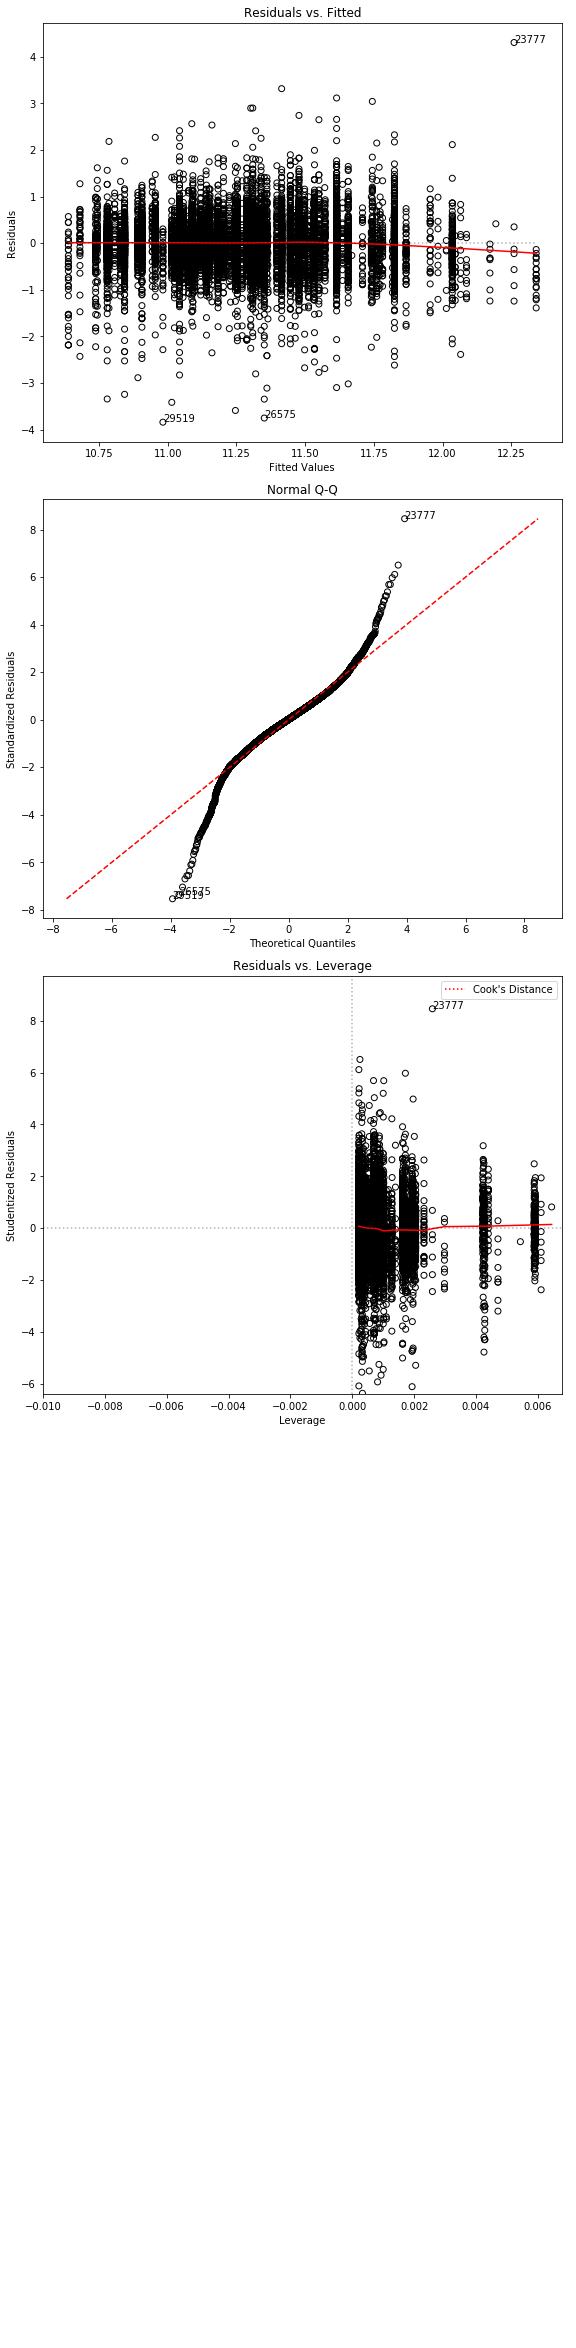

In [46]:
fig, axes = plt.subplots(3, figsize = (8, 20))

p1, top3_1 = residual_fitted_plot(results, axes[0])
p2, top3_2 = qq_plot(results, axes[1])
p3, top3_3 = leverage_plot(results, axes[2])

top3 = top3_1 + top3_2 + top3_3

plt.show()

This model performed slightly better than the previous model, but it still does not fit the data the best.

# Final Model
For this model, I will remove 5% of the data from the head and tail. The $R^2$ is slightly lower than the previous model, but it seems like a better fit based on AIC and log-likelihood.

In [47]:
salary_df_sorted = salary_df.sort_values("salary_usd")

rows_to_remove = len(salary_df_sorted) // 20

salary_df_trim = salary_df_sorted.iloc[835:-836, :]

In [48]:
salary_df_trim.head()

,age,industry,job_title,salary,currency,location,experience,context,other_currency,salary_clean,age_num,exp_num,job_category,salary_usd,log_salary
6150,45-54,Acedemia,Office Associate,"34,500",USD,Wisconsin,21 - 30 years,I work in facilities at a major university,NaN,34500.0,50.0,25.5,office,34500.0,10.448715
9482,25-34,Education (public),Library media specialist,34500,USD,Maryland,5-7 years,I'm a .6FTE elementary school librarian in a p...,NaN,34500.0,30.0,6.0,academic,34500.0,10.448715
4940,25-34,Marketing for a legal association,Digital Marketing Coordinator,"34,500",USD,"Chicago, IL",2 - 4 years,NaN,NaN,34500.0,30.0,3.0,marketing,34500.0,10.448715
3347,35-44,Higher education,Executive Project Coordinator,34500,USD,"Pittsburgh, PA",11 - 20 years,NaN,NaN,34500.0,40.0,15.5,academic,34500.0,10.448715
12372,25-34,Property Management,Office Manager,34560,USD,Pittsburgh PA,2 - 4 years,NaN,NaN,34560.0,30.0,3.0,office,34560.0,10.450452


In [49]:
model = smf.ols(formula = 'log_salary ~ exp_num + job_category', data = salary_df_trim)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             log_salary   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.250
Method:                 Least Squares   F-statistic:                     455.5
Date:                Sun, 07 Jun 2020   Prob (F-statistic):               0.00
Time:                        22:24:59   Log-Likelihood:                -6402.8
No. Observations:               15029   AIC:                         1.283e+04
Df Residuals:                   15017   BIC:                         1.292e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

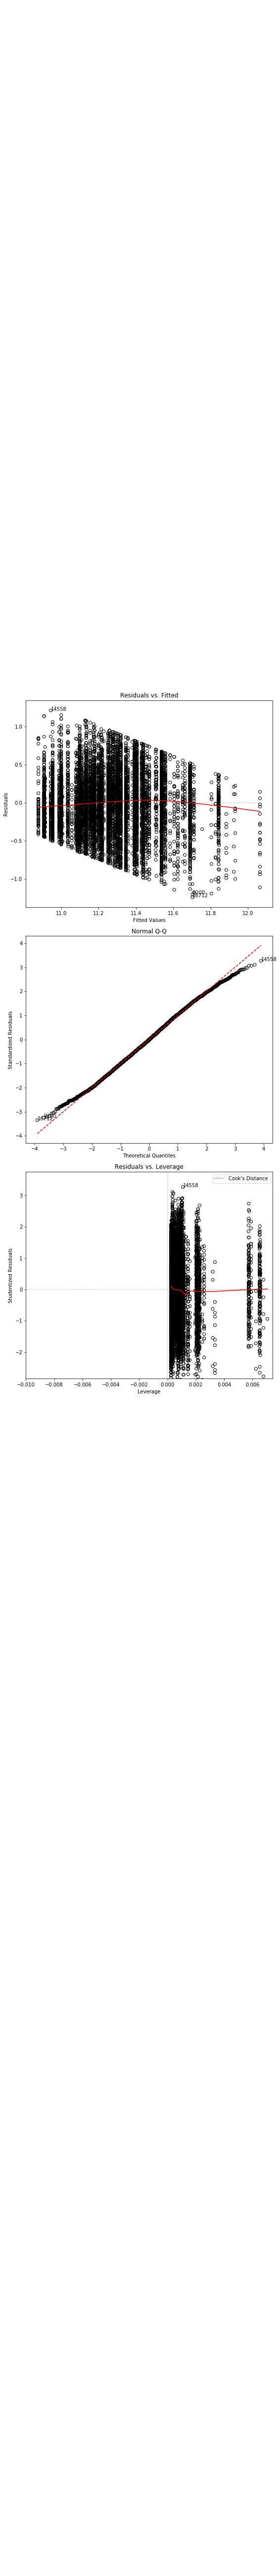

In [50]:
fig, axes = plt.subplots(3, figsize = (8, 20))

p1, top3_1 = residual_fitted_plot(results, axes[0])
p2, top3_2 = qq_plot(results, axes[1])
p3, top3_3 = leverage_plot(results, axes[2])

top3 = top3_1 + top3_2 + top3_3

plt.show()

# Note: I have no idea why these plots have all of the extra whitespace

###  Examine outliers

In [51]:
salary_df_trim.loc[top3.index, :]

,age,industry,job_title,salary,currency,location,experience,context,other_currency,salary_clean,age_num,exp_num,job_category,salary_usd,log_salary
16712,55-64,Home management,Household manager,"35,000",USD,"Raleigh, NC",31 - 40 years,NaN,NaN,35000.0,60.0,35.5,management,35000.0,10.463103
14558,25-34,Human Capital Management - SaaS,Sr. Account Executive,190000,USD,"Seattle, WA",2 - 4 years,NaN,NaN,190000.0,30.0,3.0,office,190000.0,12.154779
9200,55-64,non-profit,CEO,36400,USD,Springfield/Vermont/USA,31 - 40 years,NaN,NaN,36400.0,60.0,35.5,management,36400.0,10.502324


# Results

In the final linear regression model, data science had the largest coefficient. That means, with years of experience held constant, someone in the data science field would be expected to make more than an individual in another job field.